<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=200 HEIGHT=200>

<CENTER>
</br>
<p><font size="6"> TAF MCE - UE Numerical Methods</span></p>
<p><font size="4">  PROJECT Parallel computing in Julia</font></p>

**<p><font size="4">  Kévin FERREIRA, Elias TRANCHANT, Emma BONNEM </font></p>**
</p></br>
</p>
</CENTER>

# I. Introduction

The goal of this project is to implement a standard projected gradient descent algorithm by traversing each pixel of an image to be unmixed, then using Julia parallelization. 

In [1]:
using Distributed
CPU_CORES = 4 # number of cores on the machine
addprocs(CPU_CORES - 1);
@everywhere using LinearAlgebra
nprocs()
nworkers()
workers()

3-element Vector{Int64}:
 2
 3
 4

# II. Data import

In [2]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

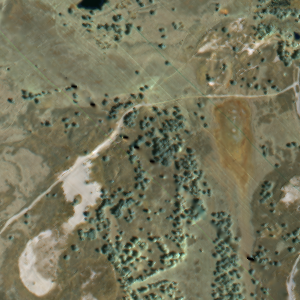

In [103]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

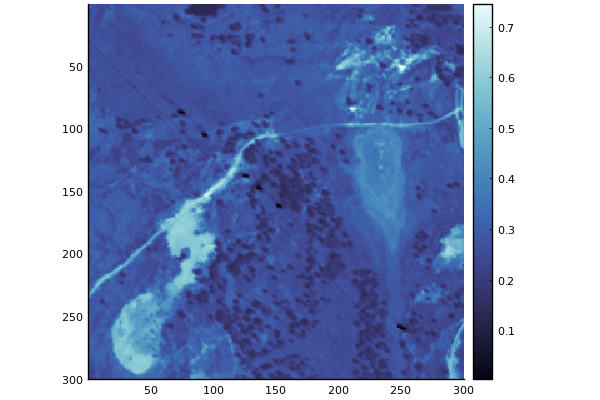

In [4]:
#visualize a spectral band on its own
p2 = heatmap(img[:,:,150],aspect_ratio=1, yflip = true,c=:ice)

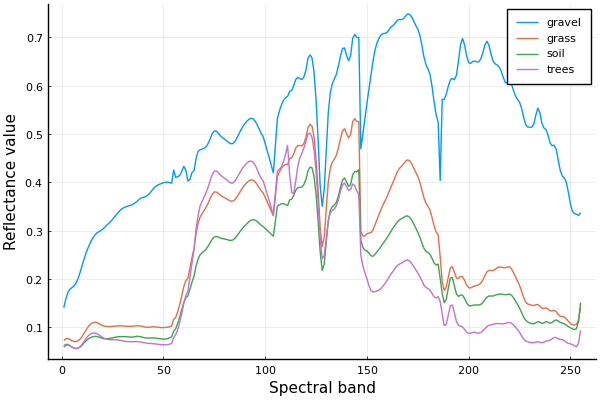

In [5]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels.
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index.

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

**First, we have to minimize: 
\begin{equation*}
f(A) = \frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = 
\frac{1}{2}(\mathbf{X}-\mathbf{SA})^{T}(\mathbf{X}-\mathbf{SA})
\end{equation*}
And its gradient is
\begin{equation*}
\nabla f(A) = S'*(S*A - X)
\end{equation*}**


At first, we will work on a small image:

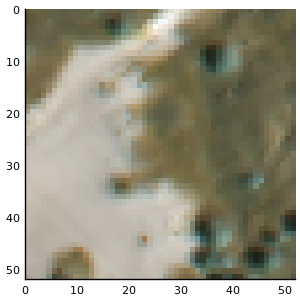

In [6]:
# load image
img_to_compute = img[150:200,70:120,:]; # use a small crop of the image first

# plot
rgb_to_compute = rgb[150:200,70:120,:]
p1 = colorview(RGB,permutedims(rgb_to_compute,(3,1,2))) # convert 3d array to the image format used by julia
plot(p1)
plot!(size=(300,300))

In [7]:
# Function to visualize all materials
#-------------------------------------
function plotMaps(img_to_compute, A)
    heatmaps = []
    labels = ["Gravel", "Grass", "Soil", "Trees"]
    for i in 1:size(S,2)
        push!(heatmaps, heatmap(reshape(A[i,:], size(img_to_compute)[1], size(img_to_compute)[1]), yflip=true, aspect_ratio=1, c=:ice, title=labels[i]))
    end
    plot(heatmaps...,layout=size(S,2), size=(800,600))
end

plotMaps (generic function with 1 method)

# III. Projected gradient descent algorithm

In this part, we implement the algorithms calculating the optimal step and the projected gradient

In [9]:
# Lipschitz
#----------

using LinearAlgebra

@everywhere function stepsize(S)
    """
    stepsize
    IN:
    ---
    S: endmember matrix
    OUT:
    ----
    s: optimal stepsize using the smallest Lipschitz constant
    """
    L = opnorm(S'*S)
    s = 2/L
    s
end

In [10]:
#Project gradient
#----------------

using LinearAlgebra: norm

@everywhere function ProjectedGradientDescent(X,S,f,∇f)
    
    """
    projected gradient descent
    IN:
    ---
    X: data matrix
    S: endmember matrix
    f, ∇f: function to be minimized and its gradient
    OUT:
    ----
    A: abundance matrix
    """
    
    N, P = size(X,2), size(S,2) # size to use
    
    # Initialization 
    A_init = max.(zeros(P,N),rand(P,N))
    A      = A_init
    
    # Parameters
    ϵ            = 1.e-4       # precision
    δ            = 1           # difference between iterations A_i and A_i+1
    opt_stepsize = stepsize(S) # optimal stepsize
    max_iter     = 10000        # maximum of iterations
    nb_iter      = 0           # number of iterations
    
    # while (||A_i - A_i+1|| > precision OR ||A_i - A_i+1|| =0) AND nb_iter < max_iter
    while ((δ > ϵ) || (δ == 0.0)) & (nb_iter < max_iter) 
        
        nb_iter += 1
        A_next = max.(zeros(P,N), A - opt_stepsize * ∇f(A,X,S)) # gradient step and taking max constraint ai>0
        
        δ = norm(A - A_next)
        A = A_next
    end
    
    # Constraint sum(ai) = 1
    A = A./sum(A, dims=1)
    A = max.(zeros(P,N), A - opt_stepsize * ∇f(A,X,S))
    A = A./sum(A, dims=1)
    
    return A
    
end

# IV. Pixelwise implementation

## a. Test of the Projected gradient descent algorithm over all image

First of all, let us define the function to be minimized and its gradient.

In [11]:
# data processing
S = sources
X = reshape(img_to_compute, size(img_to_compute)[1] * size(img_to_compute)[2], size(sources)[1])' 

# Function to minimize 
@everywhere f(A,X,S)= (1/2)*norm((X-S*A))^2
@everywhere ∇f(A,X,S) = S'*(S*A - X)

Let's apply the descent gradient by running through all the image.

In [12]:
@time begin
    A_image = ProjectedGradientDescent(X,S,f,∇f)
end

 48.759027 seconds (4.75 M allocations: 51.982 GiB, 14.47% gc time, 3.07% compilation time)


4×2601 Matrix{Float64}:
 0.0901037  0.0931288  0.0701666  0.0560944  …  0.0        0.0        0.0
 0.0        0.0        0.0        0.0           0.0943149  0.0        0.0
 0.909896   0.906871   0.929833   0.943906      0.840483   0.959327   1.0
 0.0        0.0        0.0        0.0           0.0652019  0.0406733  0.0

Let's check that the constraints are respected

In [13]:
println("Non-negativity constraint: ", min(A_image...)>=0,)
println("Sum-to-one constraint: ", sum(A_image) == size(A_image)[2])

Non-negativity constraint: true
Sum-to-one constraint: true


Let's display the image thus returned by setting a threshold so that the pixels whose intensity is lower than 0.5 are set to zero, that is to say, let's display the pixels which probably contain the elements.

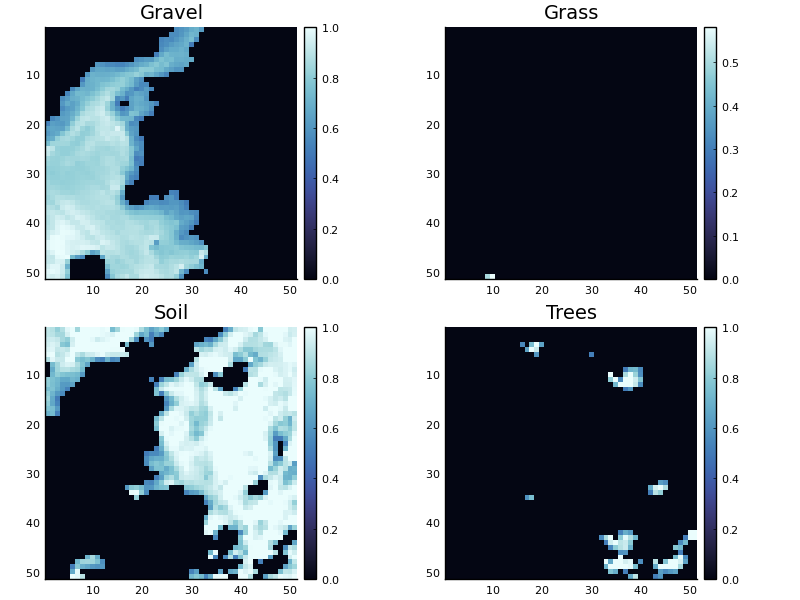

In [14]:
plotMaps(img_to_compute, A_image.*(A_image.>0.5))

## b. Test of the Projected gradient descent algorithm pixelwise

Now, let's apply the descent gradient by running through each pixel of the image.

In [15]:
@time begin
    P = size(sources)[2]
    N = size(img_to_compute)[1] * size(img_to_compute)[2]
    A_pixelwise = zeros(size(S,2), N)
    for j = 1:N
        A_pixelwise[:,j] = ProjectedGradientDescent(X[:,j],S,f,∇f)
    end
end

 19.121023 seconds (32.62 M allocations: 18.397 GiB, 29.11% gc time, 1.90% compilation time)


Let's check that the constraints are respected.

In [16]:
println("Non-negativity constraint: ", min(A_pixelwise...)>=0,)
println("Sum-to-one constraint: ", sum(A_pixelwise) == size(A_pixelwise)[2])

Non-negativity constraint: true
Sum-to-one constraint: true


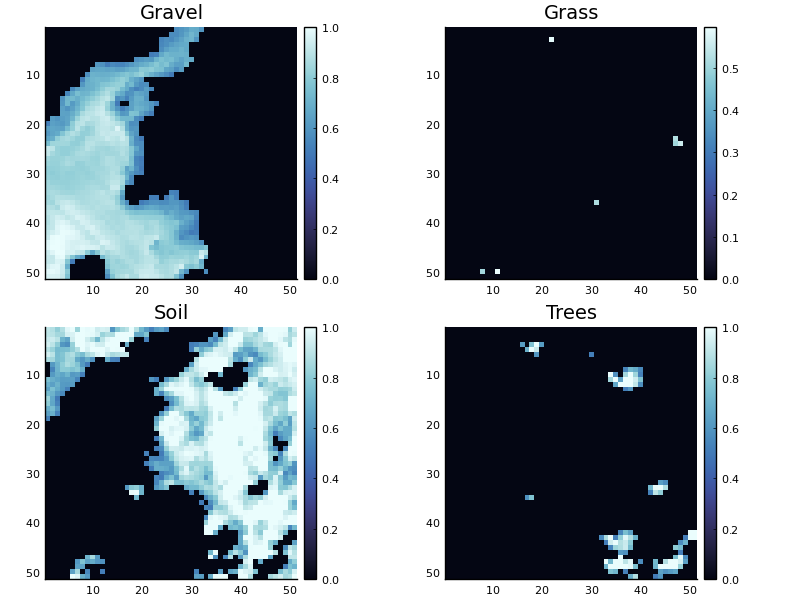

In [17]:
plotMaps(img_to_compute, A_pixelwise.*(A_pixelwise.>0.5))

**In this part, we have implemented the gradient algorithm on the whole image and then pixel by pixel. 
Regarding the results, both implementations respect the constraints imposed and give us similar results: both methods identify the materials.
However, the algorithms have different computation times. Indeed, the per-pixel approach is faster and less expensive in terms of memory usage than when the whole image is computed at once.** 

# IV. Parallel computing

In the previous section, the computation time for both implementations is still too high to apply image demining on a large image.  Therefore, we will implement the same algorithm as in the previous section but parallelizing it.

Now, let's apply the descent gradient with a parallelization.

In [18]:
using Distributed: pmap
N = size(img_to_compute)[1] * size(img_to_compute)[2]
A_parallel = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f), [X[:,j] for j = 1:N]);
A_parallel = hcat(A_parallel...)

 11.801566 seconds (4.06 M allocations: 223.661 MiB, 0.48% gc time, 14.01% compilation time)


4×2601 Matrix{Float64}:
 0.0915743  0.0947236  0.0717387  …  0.0       0.0        0.0        0.0
 0.0        0.0        0.0           0.188214  0.219194   0.0        0.0
 0.908426   0.905276   0.928261      0.811786  0.710912   0.951709   1.0
 0.0        0.0        0.0           0.0       0.0698937  0.0482913  0.0

Let's check that the constraints are respected

In [19]:
println("Non-negativity constraint: ", min(A_parallel...)>=0,)
println("Sum-to-one constraint: ", sum(A_parallel) == size(A_parallel)[2])

Non-negativity constraint: true
Sum-to-one constraint: true


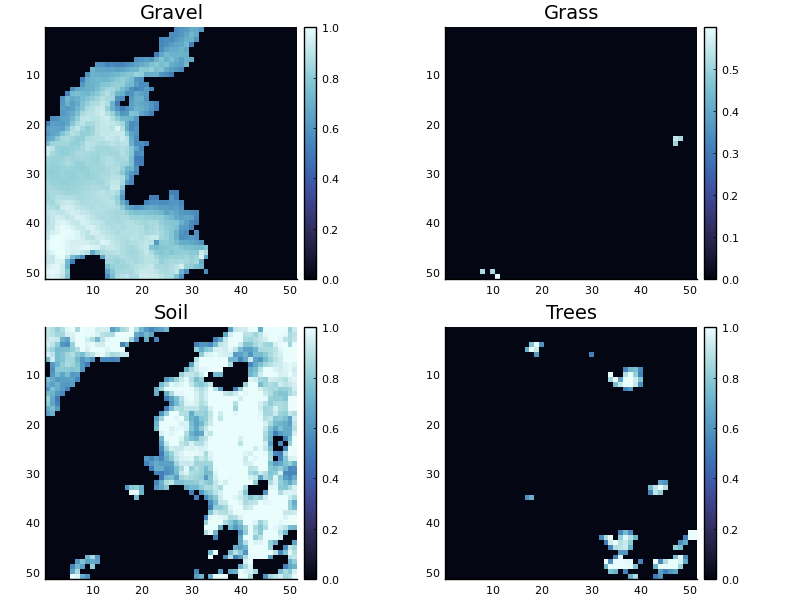

In [20]:
plotMaps(img_to_compute, A_parallel.*(A_parallel.>0.5))

**Parallelization reduces considerably the execution time using the projected gradient descent algorithm compared to the previous cases.
Moreover, the memory allocated for the computation is decreased by almost a factor of 100.
Therefore, parallelization improves the performance.** 

# V. Comparison of methods

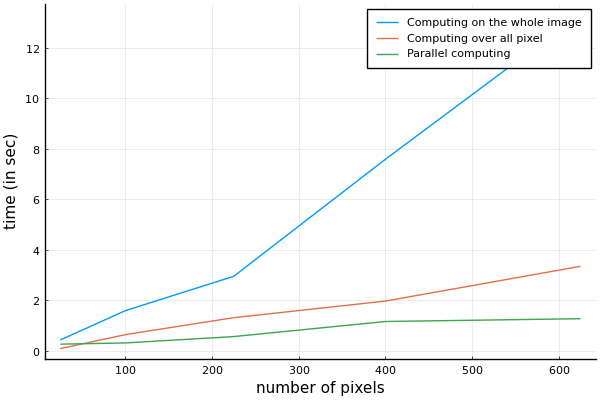

In [99]:
using Distributed: pmap

size_img      = []
time_image    = []
time_pixel    = []
time_parallel = []

for i in 1:5
    img_to_compute = img[1:5*i,1:5*i,:]
    
    P = size(sources)[2]
    N = size(img_to_compute)[1] * size(img_to_compute)[2]
    
    X = reshape(img_to_compute, size(img_to_compute)[1] * size(img_to_compute)[2], size(sources)[1])'
    
    push!(size_img, size(img_to_compute)[1]*size(img_to_compute)[2])
    
    t_image = @timed ProjectedGradientDescent(X,S,f,∇f)
    push!(time_image, t_image[2])
    
    t_pixel = @timed begin
        A_pixelwise = zeros(size(S,2), N)
        for j = 1:N
            A_pixelwise[:,j] = ProjectedGradientDescent(X[:,j],S,f,∇f)
        end
    end
    push!(time_pixel, t_pixel[2])


    t_parallel = @timed pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f), [X[:,j] for j = 1:N]);
    push!(time_parallel, t_parallel[2])

end
plot(size_img, time_image, xlabel = "number of pixels", ylabel = "time (in sec)", label = "Computing on the whole image")
plot!(size_img, time_pixel, label = "Computing over all pixel")
plot!(size_img, time_parallel, label = "Parallel computing ")

On this graph, we have plotted the computation time according to the image size for the three methods used. We can see that the computation time when we implement the calculation on the whole image explodes with the increase of the size of the image which is not necessarily the case for the two other methods despite an increase of the computation time.
However, in all cases, the parallelization is faster than the classical methods while giving equal results.

# VI. Conclusion

221.157031 seconds (6.22 M allocations: 637.604 MiB, 0.29% gc time, 0.13% compilation time)


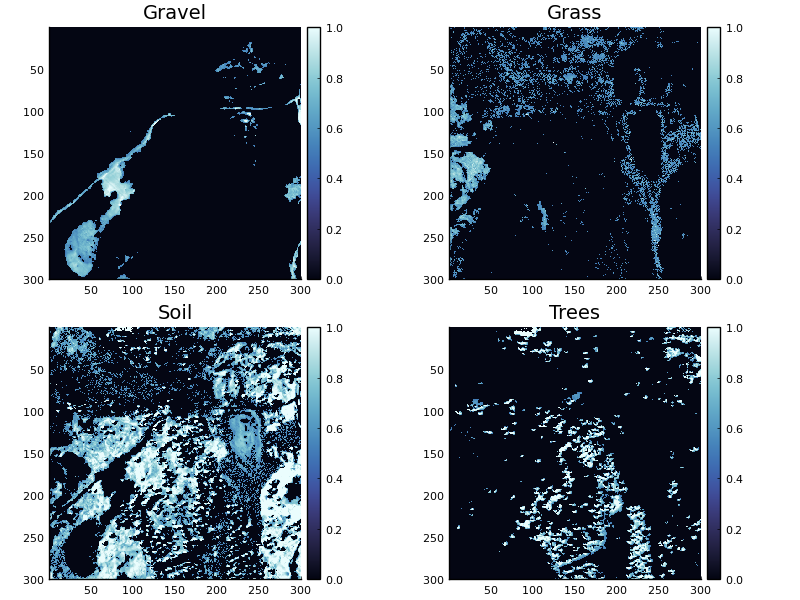

In [101]:
# load image
img_to_compute = copy(img) 

# data processing
S = sources
X = reshape(img_to_compute, size(img_to_compute)[1] * size(img_to_compute)[2], size(sources)[1])' 
size(X)

using Distributed: pmap
N = size(img_to_compute)[1] * size(img_to_compute)[2]
A_all = @time pmap(Xi->ProjectedGradientDescent(Xi,S,f,∇f), [X[:,j] for j = 1:N]);
A_all = hcat(A_all...)
plotMaps(img_to_compute, A_all.*(A_all.>0.5))

**The goal of this project was to demix a hyperspectral image using the projected gradient algorithm with two constraints in order to identify materials while introducing us to parallel computing.** 

**First, by running the classical algorithms without parallelization, the projected gradient descent algorithm works faster when implemented pixel by pixel than when working with the whole image at once.**   

**However, by parallelizing the projected gradient descent algorithm, using the pmap function of the Distributed library, the results were unchanged while significantly decreasing the computational time and memory allocated.** 

**In conclusion, before parallelizing an algorithm, it is necessary to identify the instructions that are independent between each other.**